# Cleaning Exergame SpecParam Model
After testing different model fits with `findBestModel` for Paper 1, we will use the same model to parameterize the power spectra of the independent components identified from all intervention datasets from Session 2. This will include using an **error threshold** and **R^2 threshold** identfied in the middle of the script to remove poorly fitted models before our final analysis. Note that PSDs with negative exponents are also removed.

Edited by Noor Tasnim on 11/15/2025 for Paper 2 INTERVENTION SpecParam

In [1]:
# General Imports to work with files
from scipy import io
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import h5py

# Specparam Functions
from specparam import SpectralGroupModel
from specparam.measures.error import compute_pointwise_error_group

# Custom Functions for Data Import and Cleaning
from cleanmodel_functions import *

In [2]:
# Load and process data (handles both regular and v7.3 formats)
mat_data, format_type = load_matlab_spectra('E:/Tasnim_Dissertation_Analysis/specparam_analysis/Paper 2/intervention/results/exergame_Paper2intervention_PowerSpectrumResults.mat')

if mat_data is None:
    raise ValueError("Failed to load mat file")

# Extract the data using the appropriate format
df = extract_spectra_data(mat_data, format_type)  # Note: now passing format_type

# Close the file if it's h5py to free memory
if format_type == 'h5py':
    mat_data.close()

# Access your spectra data
all_spectra = np.array([spec for spec in df['spectra']])
freqs = np.arange(251)

# Double check shapes
print(f"Frequency arrays shape is {freqs.shape}")
print(f"Spectrum array shape is {all_spectra.shape}")

# Initialize a SpectralGroupModel object, with desired settings
fg = SpectralGroupModel(peak_width_limits=[2, 8], min_peak_height=0.2, peak_threshold=2,
                        max_n_peaks=6, verbose=False)
freq_range = [1, 55]

# Fit the power spectrum model across all components
fg.fit(freqs, all_spectra, freq_range)

# Fit power spectrum models and report on the group
fg.print_results()

File appears to be MATLAB v7.3 format, loading with h5py...
Successfully loaded as HDF5/v7.3 file: E:/Tasnim_Dissertation_Analysis/specparam_analysis/Paper 2/intervention/results/exergame_Paper2intervention_PowerSpectrumResults.mat
Available variables in .mat file:
  - #refs#: <class 'h5py._hl.group.Group'>
  - results: <class 'h5py._hl.group.Group'>
Results is a structured array (Group)
Available fields in results: ['cluster', 'component', 'experience', 'filename', 'freqs', 'icaact', 'session', 'spectra', 'subject']
Checking field 'subject' with shape: (241, 1)
Determined 241 entries from field 'subject'
Processing 241 entries in results

Extracted data summary:
  Total entries: 241
  Unique subjects: 63
  Unique sessions: 1
  Unique experiences: 1
  Unique clusters: 5

Verification: Extracted 241 entries
Frequency arrays shape is (251,)
Spectrum array shape is (241, 251)
                                                                                                  
               

## Calculate Error and Underfit Threshold

In [3]:
errors = fg.get_params('error')
# Using mean + k*std for error outliers (higher errors are worse)
error_mean = np.mean(errors)
error_std = np.std(errors)
error_threshold = error_mean + 3 * error_std  # 3-sigma rule for extreme outliers

# Finding Threshold of R^2
r2s = fg.get_params('r_squared')
# Using mean - k*std for R^2 outliers (lower R^2 values are worse)
r2_mean = np.mean(r2s)
r2_std = np.std(r2s)
underfit_threshold = r2_mean - 3 * r2_std  # 3-sigma rule for extreme outliers

print(f"Error Threshold: {error_threshold} & R^2 Threshold: {underfit_threshold}")

Error Threshold: 0.15057183653987846 & R^2 Threshold: 0.44107817476987154


## Flagging and Removing High Error and Underfit Models

In [4]:
# Extract indices of models with high error (> 0.103)
error_original_indices = []
for ind, res in enumerate(fg):
    if res.error > error_threshold:
        error_original_indices.append(ind)

print(f"Number of models with Error > {error_threshold}: {len(error_original_indices)}")

# Extract indices of models with low R² (< 0.559)
underfit_original_indices = []
for ind, res in enumerate(fg):
    if res.r_squared < underfit_threshold:
        underfit_original_indices.append(ind)

print(f"Number of models with R² < {underfit_threshold}: {len(underfit_original_indices)}")

# Combine both sets of problematic indices and remove duplicates
bad_model_indices = list(set(error_original_indices + underfit_original_indices))
bad_model_indices.sort()  # Sort for easier inspection

print(f"Total unique models to remove: {len(bad_model_indices)}")
print(f"Original dataframe shape: {df.shape}")

# Create documentation of removed data
if len(bad_model_indices) > 0:
    # Extract information for removed models
    removed_data = df.loc[bad_model_indices, ['subject', 'session', 'experience', 'component', 'cluster']].copy()

    # Add reason for removal for better documentation
    removed_data['removal_reason'] = ''

    # Mark reasons for removal
    for idx in bad_model_indices:
        reasons = []
        if idx in error_original_indices:
            reasons.append(f'high_error(>{error_threshold})')
        if idx in underfit_original_indices:
            reasons.append(f'low_r_squared(<{underfit_threshold})')
        removed_data.loc[idx, 'removal_reason'] = '; '.join(reasons)

    # Add the actual error and r_squared values for reference
    removed_data['error_value'] = [fg[idx].error for idx in bad_model_indices]
    removed_data['r_squared_value'] = [fg[idx].r_squared for idx in bad_model_indices]

    # Reset index to make it cleaner
    removed_data = removed_data.reset_index().rename(columns={'index': 'original_df_index'})

    # Export to CSV
    removed_data.to_csv('E:/Tasnim_Dissertation_Analysis/specparam_analysis/Paper 2/intervention/results/removed_models_log.csv', index=False)
    print(f"Removed data documentation saved to 'removed_models_log.csv'")
    print(f"Removed data preview:")
    print(removed_data.head())
else:
    print("No models were removed - no documentation file created.")

# Remove rows corresponding to bad models from the dataframe
# Using drop with index labels
df_cleaned = df.drop(index=bad_model_indices).reset_index(drop=True)

print(f"Cleaned dataframe shape: {df_cleaned.shape}")
print(f"Removed {df.shape[0] - df_cleaned.shape[0]} rows from dataframe")

# Verify the cleaning worked
print(f"\nData quality summary:")
print(f"- Models with high error removed: {len(error_original_indices)}")
print(f"- Models with low R² removed: {len(underfit_original_indices)}")
print(f"- Total models removed: {len(bad_model_indices)}")
print(f"- Models retained: {len(df_cleaned)}")

Number of models with Error > 0.15057183653987846: 4
Number of models with R² < 0.44107817476987154: 8
Total unique models to remove: 12
Original dataframe shape: (241, 9)
Removed data documentation saved to 'removed_models_log.csv'
Removed data preview:
   original_df_index  subject session    experience  component  cluster  \
0                 49  exgm193      s2  intervention          4        3   
1                 55  exgm012      s2  intervention          3        4   
2                 73  exgm090      s2  intervention          1        4   
3                 87  exgm145      s2  intervention          1        4   
4                 88  exgm146      s2  intervention          2        4   

                        removal_reason  error_value  r_squared_value  
0     high_error(>0.15057183653987846)     0.175181         0.740983  
1  low_r_squared(<0.44107817476987154)     0.071573         0.035149  
2  low_r_squared(<0.44107817476987154)     0.089010         0.363104  
3     high

## Running SpecParam on Cleaner Model

                                                                                                  
                                          GROUP RESULTS                                           
                                                                                                  
                            Number of power spectra in the Group: 229                             
                                                                                                  
                        The model was run on the frequency range 1 - 55 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                              Power spectra were fit without a knee.                              
                                                                                                  
          

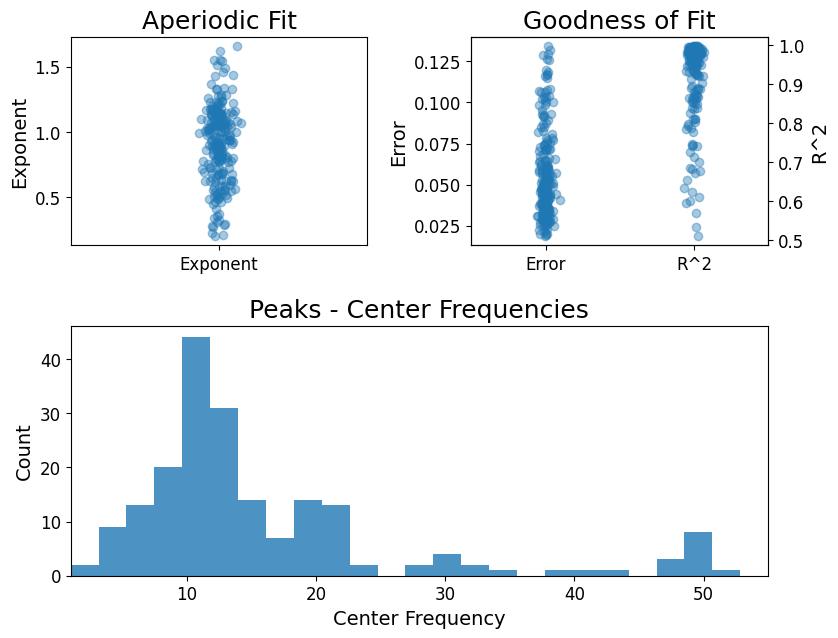

In [5]:
cleaned_spectra = np.array([spec for spec in df_cleaned['spectra']])
# Initialize and fit new SpectralGroupModel on cleaned data
fg_cleaned = SpectralGroupModel(peak_width_limits=[2, 8], min_peak_height=0.2, peak_threshold=2,
                               max_n_peaks=6, verbose=False)
fg_cleaned.fit(freqs, cleaned_spectra, freq_range)

# Fit power spectrum models and report on the group
fg_cleaned.print_results()
fg_cleaned.plot()

# Check the overall results of the group fits and save as PDF
fg_cleaned.save_report(f"E:/Tasnim_Dissertation_Analysis/specparam_analysis/Paper 2/intervention/results/GroupReportAfterThresholding")

## Removing Negative Exponent Models
It's highly unlikely for a power spectral model to have a negative exponent given its expected 1/f nature. So, we'll skim through the new model's fit spectra and remove any spectra with a negative exponent.

Because the exponent is a part of the aperiodic parameters of the spectral model, we'll need to access it through `res.aperiodic_params`. Note that it is the second value in the array. The first value is the offset.

In [6]:
# Extract models with negative exponents
# The exponent is the second value in aperiodic_params (index 1)
negative_exponent_indices = []
for ind, res in enumerate(fg_cleaned):
    if res.aperiodic_params[1] < 0:  # exponent is negative
        negative_exponent_indices.append(ind)

print(f"\nNumber of models with negative exponents: {len(negative_exponent_indices)}")

# Create documentation of models with negative exponents
if len(negative_exponent_indices) > 0:
    # Extract information for models with negative exponents
    negative_exp_data = df_cleaned.iloc[negative_exponent_indices][['subject', 'session', 'experience', 'component', 'cluster']].copy()

    # Add removal reason and exponent values for documentation
    negative_exp_data['removal_reason'] = 'negative_exponent'
    negative_exp_data['exponent_value'] = [fg_cleaned[idx].aperiodic_params[1] for idx in negative_exponent_indices]

    # Add original indices from df_cleaned for traceability
    negative_exp_data = negative_exp_data.reset_index().rename(columns={'index': 'df_cleaned_index'})

    # Add filename for cross-reference with saved plots
    negative_exp_data['plot_filename'] = negative_exp_data.apply(
        lambda row: f"{row['subject']}_{row['session']}_{row['experience']}_IC{row['component']}_Cluster{row['cluster']}.png",
        axis=1
    )

    # Export to CSV
    negative_exp_data.to_csv('E:/Tasnim_Dissertation_Analysis/specparam_analysis/Paper 2/intervention/results/negative_exponent_models_log.csv', index=False)
    print(f"Negative exponent models documentation saved to 'negative_exponent_models_log.csv'")
    print(f"Negative exponent data preview:")
    print(negative_exp_data.head())
else:
    print("No models with negative exponents found - no documentation file created.")

# Create directory for negative exponent models
negative_exp_dir = "E:/Tasnim_Dissertation_Analysis/specparam_analysis/Paper 2/intervention/results/negativeExponents/"
os.makedirs(negative_exp_dir, exist_ok=True)

# Plot and save models with negative exponents
for i, model_ind in enumerate(negative_exponent_indices):
    # Get the model from fg_cleaned
    fm = fg_cleaned.get_model(model_ind, regenerate=True)

    # Extract subject, session, experience, and component from df_cleaned using the index
    subject = df_cleaned.iloc[model_ind]['subject']
    session = df_cleaned.iloc[model_ind]['session']
    experience = df_cleaned.iloc[model_ind]['experience']
    component = df_cleaned.iloc[model_ind]['component']
    cluster = df_cleaned.iloc[model_ind]['cluster']

    # Create the plot
    fig = fm.plot()

    # Create filename with extracted information
    filename = f"{subject}_{session}_{experience}_IC{component}_Cluster{cluster}.png"

    # Save the figure
    plt.savefig(f"{negative_exp_dir}/{filename}", dpi=300, bbox_inches='tight')

    # Close the figure to free memory
    plt.close(fig)

print(f"All {len(negative_exponent_indices)} negative exponent models saved to: {negative_exp_dir}")

# Remove models with negative exponents from df_cleaned to create df_final
df_final = df_cleaned.drop(index=df_cleaned.index[negative_exponent_indices]).reset_index(drop=True)

print(f"\nFinal data summary:")
print(f"- df_cleaned shape: {df_cleaned.shape}")
print(f"- Models with negative exponents removed: {len(negative_exponent_indices)}")
print(f"- df_final shape: {df_final.shape}")
print(f"- Total models removed from original data: {df.shape[0] - df_final.shape[0]}")


Number of models with negative exponents: 0
No models with negative exponents found - no documentation file created.
All 0 negative exponent models saved to: E:/Tasnim_Dissertation_Analysis/specparam_analysis/Paper 2/intervention/results/negativeExponents/

Final data summary:
- df_cleaned shape: (229, 9)
- Models with negative exponents removed: 0
- df_final shape: (229, 9)
- Total models removed from original data: 12


## Run final dataframe through SpecParam, save outputs for analysis on separate script

                                                                                                  
                                          GROUP RESULTS                                           
                                                                                                  
                            Number of power spectra in the Group: 229                             
                                                                                                  
                        The model was run on the frequency range 1 - 55 Hz                        
                                 Frequency Resolution is 1.00 Hz                                  
                                                                                                  
                              Power spectra were fit without a knee.                              
                                                                                                  
          

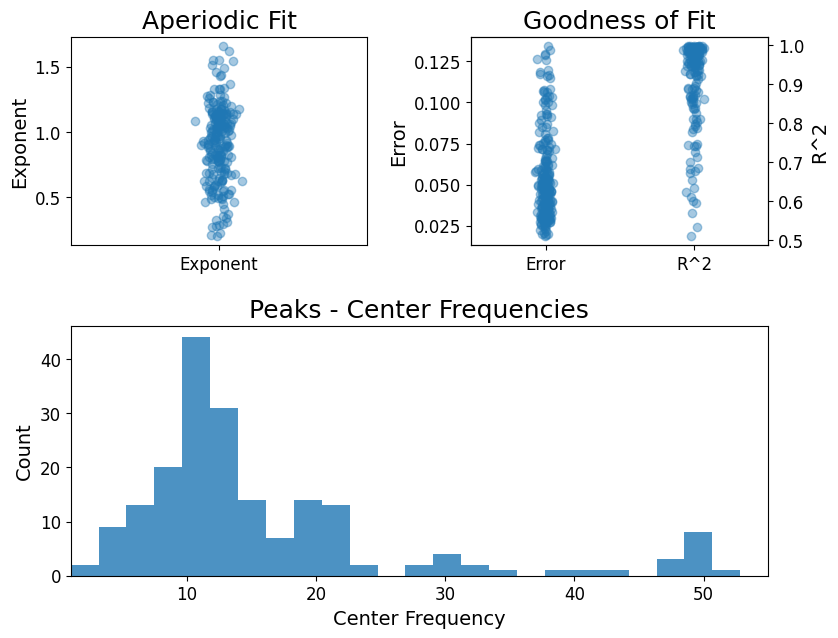

In [7]:
# Extract spectra from final dataframe
final_spectra = np.array([spec for spec in df_final['spectra']])
# Initialize and fit new SpectralGroupModel on cleaned data
fg_final = SpectralGroupModel(peak_width_limits=[2, 8], min_peak_height=0.2, peak_threshold=2,
                               max_n_peaks=6, verbose=False)
fg_final.fit(freqs, final_spectra, freq_range)

# Fit power spectrum models and report on the group
fg_final.print_results()
fg_final.plot()

# Check the overall results of the group fits and save as PDF
fg_final.save_report(f"E:/Tasnim_Dissertation_Analysis/specparam_analysis/Paper 2/intervention/results/FinalGroupReport")

# Save final dataframe for thorough analysis
df_final.to_pickle('E:/Tasnim_Dissertation_Analysis/specparam_analysis/Paper 2/intervention/results/Paper2_Intervention_df_final.pkl')